# Mask R-CNN - HandTrackingThroughDetection

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import cv2

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
class_names = ("BG","Hand")


# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases


/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/shri/shri3/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.

## Configurations

In [2]:
class handConfig(Config):
    
    NAME = "hand"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  
    STEPS_PER_EPOCH = 1000
    # DETECTION_MIN_CONFIDENCE = 0.1
    # RPN_NMS_THRESHOLD = 0.1

    # DETECTION_NMS_THRESHOLD = 0.1
    # tf.global_variables_initializer()



class InferenceConfig(handConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

def load_model_custom(config):
#     with tf.device(DEVICE):

    model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./model')
    model.load_weights('./model/trained_weights.h5', by_name=True)
        # print(model.summary())

    return model
model = load_model_custom(InferenceConfig())





(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)



(None, None, None, 1024)
SHape of theta = (?, 4096, 256) Shape of fi (?, 4096, 256)
SHape of f = (?, 4096, 4096) Shape of g (?, 4096, 256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


## Notebook Preferences

In [3]:
gt_class_id = [0,1]

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Run Detection

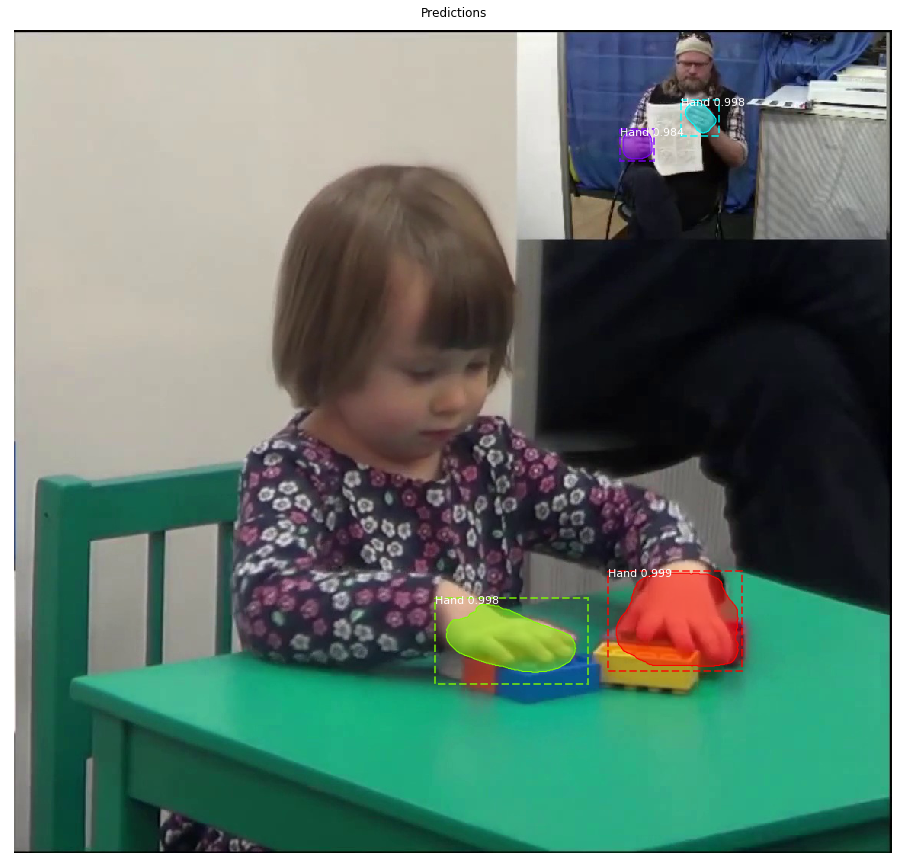

In [5]:
frame_path = "/scratch/shri/Projects/Hand-CNN/frame_output/Frame141.jpg"
image = skimage.io.imread(frame_path)
frames = []
# for files in os.listdir(frame_path)[:2]:
#     print(files)
#     frames.append(skimage.io.imread(frame_path+files)) 
# image = cv2.imread(frame_path)
# print(image)
# img_origin = skimage.io.imread(frame_path)
# img = img_origin.copy()
# print(np.shape(img))

# for frame in frames:
    
results = model.detect([image], verbose=0)

# results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["BG","Hand"], r['scores'], ax=ax,
                            title="Predictions")


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [6]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

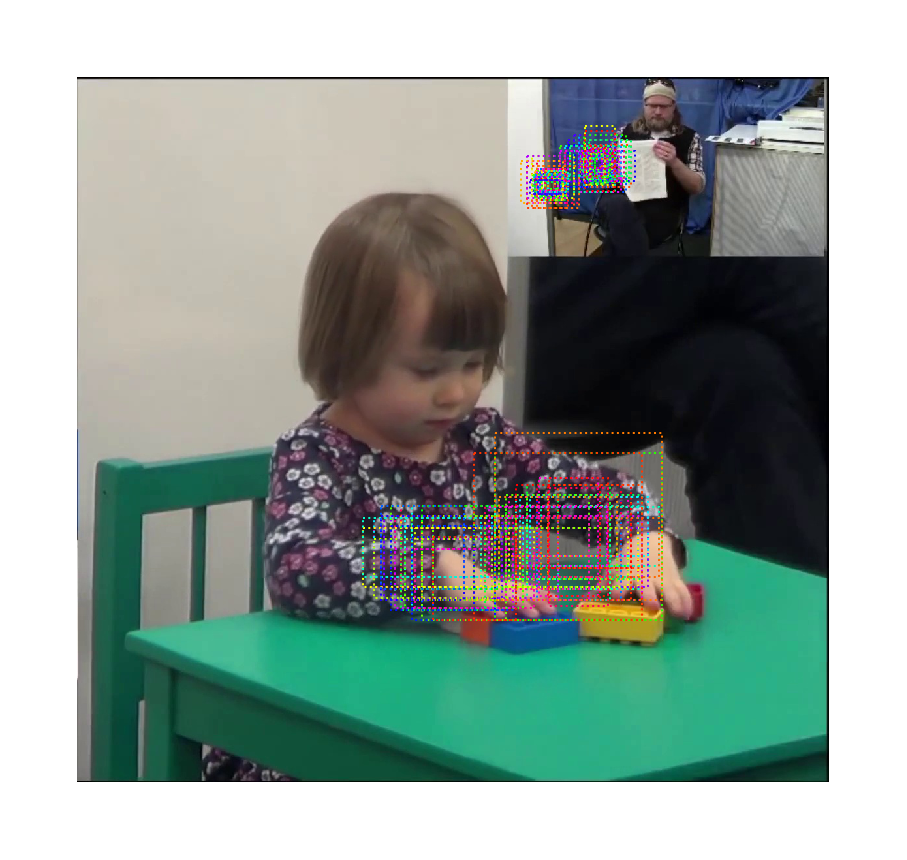

In [7]:
# Show top anchors by score (before refinement)
limit = 200
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

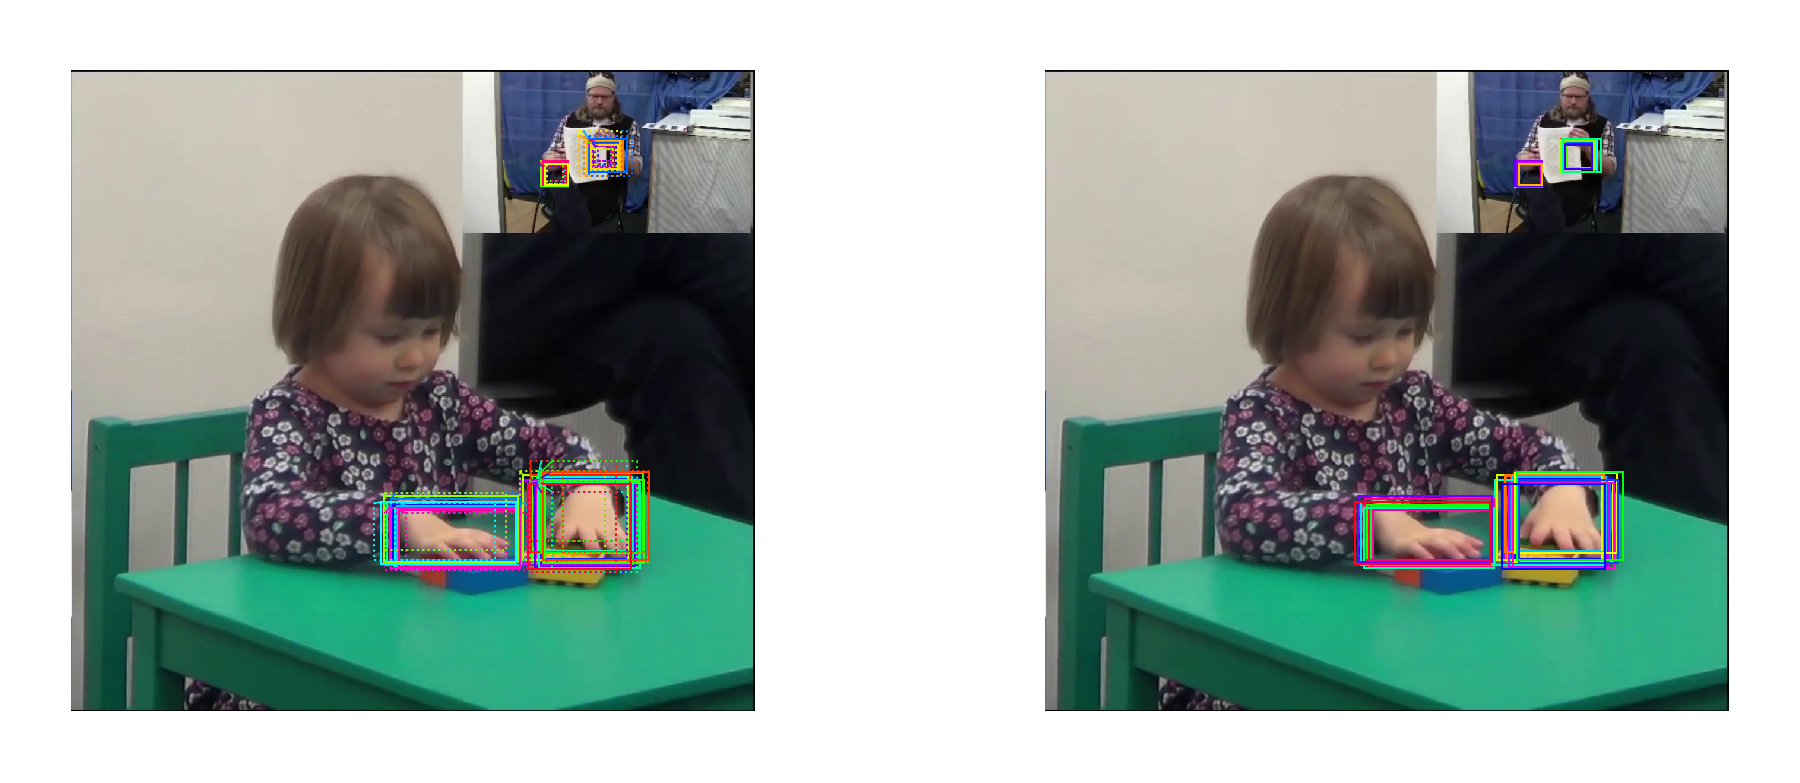

In [8]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

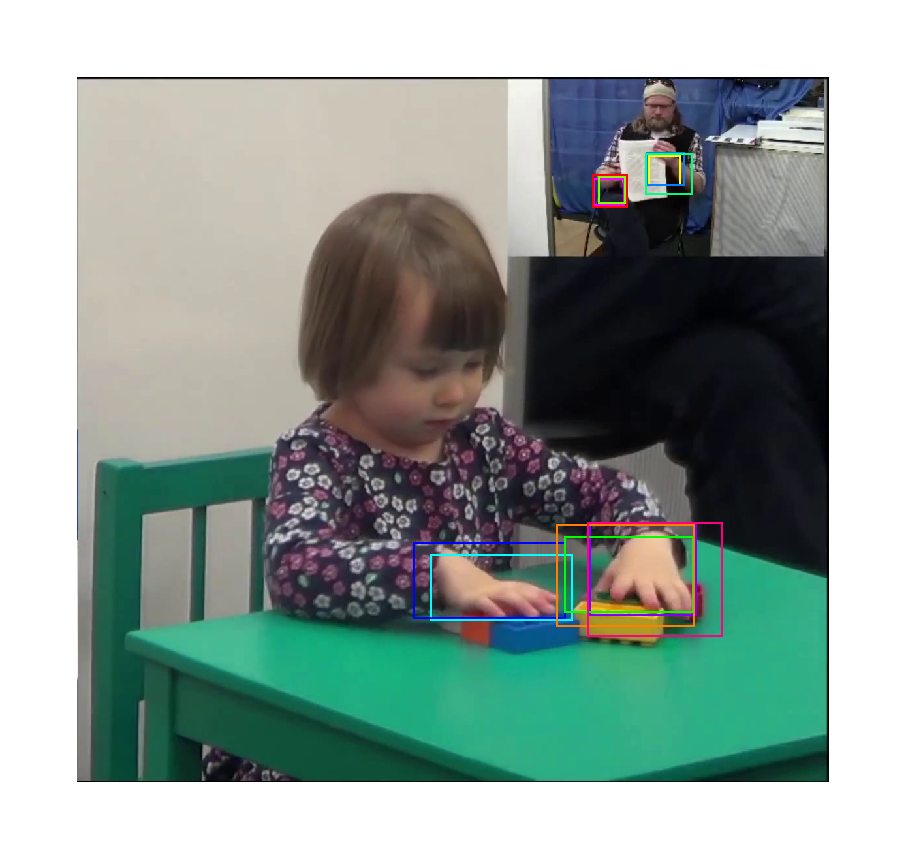

In [9]:
# Show refined anchors after non-max suppression
limit = 12
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())



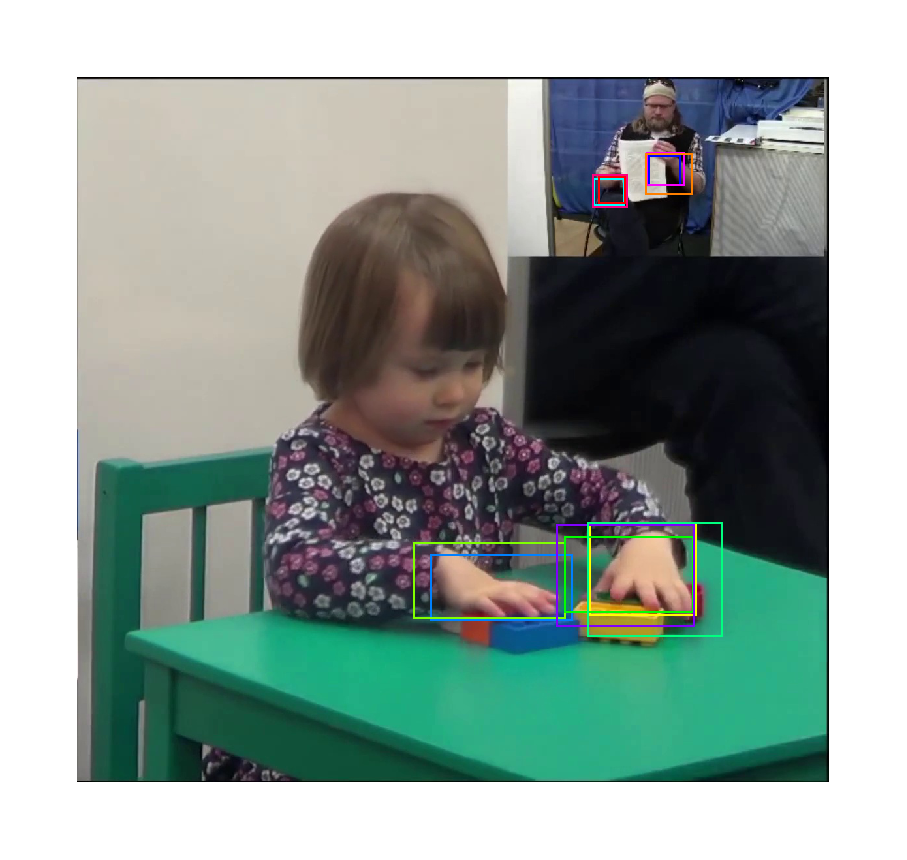

In [10]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 12
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2])
# proposals = rpn['proposals'][0, :limit] * np.array([w, h, w, h])
# print(proposals)

visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

In [11]:
# a = model.run_graph([image], [
#     ("b_boxes",model.keras_model.get_layer("roi_align_classifier").output)])

# mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_orientation=\
#                 fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
#                                      config.POOL_SIZE, config.NUM_CLASSES,
#                                      train_bn=config.TRAIN_BN,
#                                      fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

In [12]:
# print(a.keys())
# # a["b_boxes"]

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [13]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [18]:
limit = 1000
proposals = utils.denorm_boxes(mrcnn['proposals'][0, :limit], image.shape[:2])

roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]
# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))



# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))
# visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())


### Refinement

roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)#.astype(np.int32)

1000 Valid proposals out of 1000
53 Positive ROIs
Keep 53 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  38  41  43  46  54  55  60  61  62  65  87  88  94 181 242 573]
Remove boxes below 0.7 confidence. Keep 48:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  38  41  43  54  55  60  61  62  65  87  94 242]
[('BG', 947), ('Hand', 53)]


[[[697.10504, 780.77057, 822.0503, 953.5534], 0.9984281], [[119.47417, 873.8339, 163.30873, 924.29034], 0.99821544], [[732.53644, 551.8889, 837.9881, 752.88], 0.99832755], [[153.68787, 794.5343, 195.58427, 837.8042], 0.97920954], [[118.39254, 873.1754, 161.67395, 924.3625], 0.9975975], [[154.67563, 795.06586, 194.37378, 838.1165], 0.9674406], [[732.6036, 552.7725, 835.3927, 746.63403], 0.9950641], [[698.4059, 779.2008, 821.85114, 954.9582], 0.9991129], [[118.341064, 872.9402, 163.75125, 926.6994], 0.97174597], [[696.64026, 776.8889, 828.1414, 957.356], 0.9974433], [[153.28848, 793.5974, 194.37694, 839.0547], 0.97337013], [[692.79193, 775.47345, 828.5017, 962.13367], 0.99686795], [[732.75146, 555.48706, 836.6958, 747.0889], 0.99781275], [[118.17279, 874.3566, 162.97318, 924.6276], 0.99286556], [[155.69968, 795.07153, 194.45036, 839.1606], 0.9716259], [[152.0646, 792.88354, 197.18964, 841.9769], 0.8993145], [[155.5116, 793.98474, 195.35902, 838.1795], 0.9580779], [[154.50816, 796.9125, 1

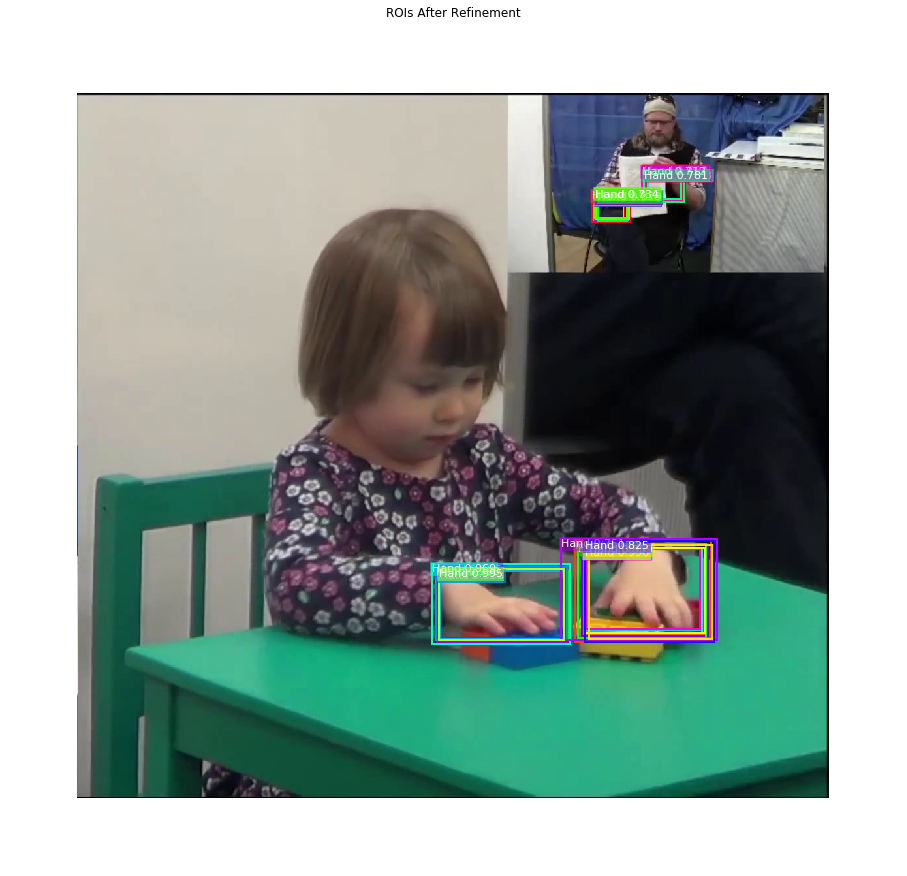

In [22]:
# Show positive proposals
limit = 30
ids = np.arange(0, len(keep)-1)  # Display all
# ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
# ids = roi_positive_ixs[:-1]
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ids], roi_scores[keep][ids])]

# keep = np.where(roi_class_ids > 0)[0]
# print("Keep {} detections:\n{}".format(keep.shape[0], keep))
# keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
# print("Remove boxes below {} confidence. Keep {}:\n{}".format(
#     config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))


# ids = keep
# visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
#                      refined_boxes=refined_proposals[roi_positive_ixs][ids],
#                      visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
#                      captions=captions, title="ROIs After Refinement",
#                      ax=get_ax())

visualize.draw_boxes(image, 
                     refined_boxes=refined_proposals[keep][ids],
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

final_bboxes_before_NMS = []

for bboxes , score in zip(refined_proposals[keep][ids],roi_scores[keep][ids]):
    final_bboxes_before_NMS.append([list(bboxes),score])
    
print(final_bboxes_before_NMS)


In [ ]:
# Get detection class IDs. Trim zero padding.
class_names = ("BG","Hand")
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]

print(captions)
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[1] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())